In [1]:
import re
import os
import json
import time
import math
import logging
import requests
import folium
import pandas as pd
import random
import seaborn as sns
import webbrowser
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from lxml import etree
from datetime import datetime
from bs4 import BeautifulSoup

plt.style.use("ggplot")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif']=['SimHei'] 

In [2]:
# 读取抓包获得的米其林app的json文件
# 米其林App一次性将数据读取拉到本地，因此可以获得全量的米其林餐厅数据
f = open("michelin_res.json", encoding='utf-8')
michelin = json.load(f)
all_michelin_lis = michelin['restaurant']

In [3]:
# 循环读取米其林餐厅列表，读取关键信息放入dataframe内
michelin_df = pd.DataFrame()
for i in range(len(all_michelin_lis)):
    single_michelin_dic = all_michelin_lis[i]
    mcl_id = single_michelin_dic['id'] # 餐厅id
    mcl_name = single_michelin_dic['name'] # 餐厅名
    mcl_star = single_michelin_dic['star'] # 餐厅米其林星级
    mcl_city = single_michelin_dic['city'] # 餐厅城市
    mcl_poi = single_michelin_dic['coordinate_amap'] # 餐厅poi
    mcl_address = single_michelin_dic['address'] # 餐厅地址
    mcl_short_address = single_michelin_dic['short_address'] # 餐厅短地址
    mcl_has_set = single_michelin_dic['has_set'] # 餐厅有无套餐
    mcl_dinner_menu_min = single_michelin_dic['dinner_menu_min'] # 晚间单点最低价
    mcl_dinner_menu_max = single_michelin_dic['dinner_menu_max'] # 晚间单点最高价
    mcl_dinner_set_min = single_michelin_dic['dinner_set_min'] # 晚间套餐最低价
    mcl_dinner_set_max = single_michelin_dic['dinner_set_max'] # 晚间套餐最高价
    mcl_lunch_menu_min = single_michelin_dic['lunch_menu_min'] # 午间单点最低价
    mcl_lunch_menu_max = single_michelin_dic['lunch_menu_max'] # 午间单点最高价
    mcl_lunch_set_min = single_michelin_dic['lunch_set_min'] # 午间套餐最低价
    mcl_lunch_set_max = single_michelin_dic['lunch_set_max'] # 午间套餐最高价
    dic = {'mcl_id': mcl_id, # 餐厅id
           'mcl_name': mcl_name, # 餐厅名
           'mcl_star': mcl_star, # 餐厅米其林星级
           'mcl_poi': mcl_poi, # 餐厅poi
           'mcl_address': mcl_address, # 餐厅地址
           'mcl_short_address': mcl_short_address, # 餐厅短地址
           'mcl_has_set': mcl_has_set, # 餐厅有无套餐
           'mcl_dinner_menu_min': mcl_dinner_menu_min, # 晚间单点最低价
           'mcl_dinner_menu_max': mcl_dinner_menu_max, # 晚间单点最高价
           'mcl_dinner_set_min': mcl_dinner_set_min, # 晚间套餐最低价
           'mcl_dinner_set_max': mcl_dinner_set_max, # 晚间套餐最高价
           'mcl_lunch_menu_min': mcl_lunch_menu_min, # 午间单点最低价
           'mcl_lunch_menu_max': mcl_lunch_menu_max, # 午间单点最高价
           'mcl_lunch_set_min': mcl_lunch_set_min, # 午间套餐最低价
           'mcl_lunch_set_max': mcl_lunch_set_max, # 午间套餐最高价
           'mcl_city': mcl_city } # 城市 8D553380-2180-440A-8E3E-6F926CCB77F6 北京
    michelin_df = michelin_df.append(pd.DataFrame.from_dict(dic, orient='index').T)

In [4]:
# 星级字典，将数据翻译成星级
star_dic = {'0590FDA9-9DC0-4ACE-BFEA-83A57FDFB15F': '☆☆☆', 'D2CC5438-B44C-436B-9D9C-4BEC4564CE79': '☆☆☆', 'DC960ECC-E15B-46E2-89F5-B44EC31743F1': '☆☆', 'D2CC5438-B44C-436B-9D9C-4BEC4564CE79': '☆', 'D87A87B3-782B-4C02-83FE-C0467D934923':'米其林餐盘', 'DE23F387-79CE-4992-9398-697AE70F017C':'必比登推介', '58B8EF0B-024A-4581-831B-0B73AA35058D': '街头美食'}
# 城市字典，将数据翻译成城市
city_dic = {'6B70D2A3-8061-F37D-73DB-355134A0521F': '上海', 'ECCFF058-9506-4187-536C-EE8A39B5D79D': '香港', '8D553380-2180-440A-8E3E-6F926CCB77F6': '北京', '38E469DD-34B7-347A-9C77-D0B1F326B0C5': '澳门', 'E9E7F1CC-2414-4FB1-AC40-282424CC36ED':'广州', '834FA3FA-1B9F-4771-B43B-A43F3FE940CC':'台北'}

In [5]:
michelin_df = michelin_df.reset_index(drop=True)
michelin_df['star'] = '' # 根据star_dic翻译星级
michelin_df['city'] = '' # 根据city_dic翻译城市
for i in range(len(michelin_df)):
    michelin_df.loc[i, 'star'] = star_dic[michelin_df.loc[i, 'mcl_star']]
    michelin_df.loc[i, 'city'] = city_dic[michelin_df.loc[i, 'mcl_city']]

# 米其林热力图（北京上海对比）

In [6]:
# 转化poi数据
def convert_poi2lis(df):
    # poi数据转化为可以绘制热力图的list
    df = df[df['mcl_poi'] != ',']
    df = df.reset_index(drop=True)
    for i in range(len(df)):
        try:
            df.loc[i,'lat'] = float(df.loc[i,'mcl_poi'].split(',')[1])
            df.loc[i,'lng'] = float(df.loc[i,'mcl_poi'].split(',')[0])
        except:
            print(df.loc[i, 'mcl_name']) # 没有poi数据
            continue
    poi_lis = [[row['lat'], row['lng']] for name, row in df.iterrows()]
    return poi_lis

In [7]:
michelin_pos_lis = convert_poi2lis(michelin_df)

In [8]:
michelin_heatmap = folium.Map(location=[39.9527, 116.4317], zoom_start=11.5)
michelin_heatmap.add_children(HeatMap(michelin_pos_lis))
michelin_heatmap.save("michelin_heatmap_北京.html")

/Users/patientman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  


In [9]:
# 北京热力图
michelin_heatmap

In [10]:
michelin_heatmap = folium.Map(location=[31.2327, 121.47], zoom_start=11.5)
michelin_heatmap.add_children(HeatMap(michelin_pos_lis))
michelin_heatmap.save("michelin_heatmap_上海.html")

/Users/patientman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  


In [11]:
# 上海热力图
michelin_heatmap

In [12]:
michelin_df[michelin_df['city'] == '北京'].groupby('mcl_short_address').count().sort_values('mcl_id')

,mcl_id,mcl_name,mcl_star,mcl_poi,mcl_address,mcl_has_set,mcl_dinner_menu_min,mcl_dinner_menu_max,mcl_dinner_set_min,mcl_dinner_set_max,mcl_lunch_menu_min,mcl_lunch_menu_max,mcl_lunch_set_min,mcl_lunch_set_max,mcl_city,star,city
mcl_short_address,,,,,,,,,,,,,,,,,
海淀区,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
西城区,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
东城区,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
朝阳区,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51


In [13]:
michelin_df[michelin_df['city'] == '上海'].groupby('mcl_short_address').count().sort_values('mcl_id')

,mcl_id,mcl_name,mcl_star,mcl_poi,mcl_address,mcl_has_set,mcl_dinner_menu_min,mcl_dinner_menu_max,mcl_dinner_set_min,mcl_dinner_set_max,mcl_lunch_menu_min,mcl_lunch_menu_max,mcl_lunch_set_min,mcl_lunch_set_max,mcl_city,star,city
mcl_short_address,,,,,,,,,,,,,,,,,
虹口区,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
闵行区,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
长宁区,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
徐汇区,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
浦东新区,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
静安区,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
黄浦区,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59


# 米其林城市间对比

## 整体数量对比

In [14]:
city_num_df = pd.DataFrame(michelin_df.groupby(['city']).count()['mcl_id'])

In [15]:
city_num_df = city_num_df.reset_index()

In [16]:
city_num_df.rename(columns={'mcl_id': '米其林餐厅数量', 'city':'城市'}, inplace=True)

In [17]:
city_num_df = city_num_df.sort_values('米其林餐厅数量', ascending=False)

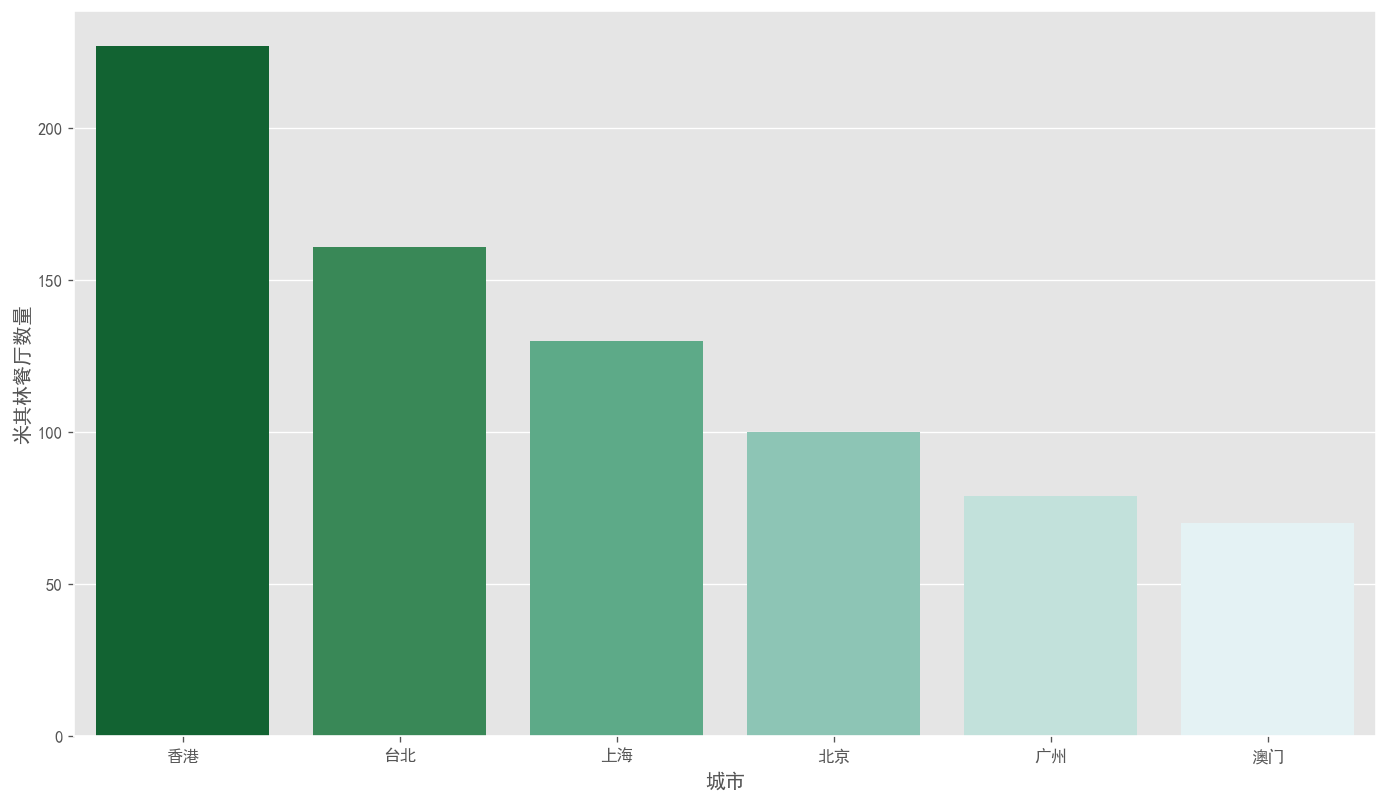

In [18]:
fig = plt.figure(figsize=(14,8), dpi=120)
sns.barplot(x="城市",y="米其林餐厅数量",data=city_num_df,palette='BuGn_r')
plt.savefig("2-米其林各城市总体数量.jpg")
plt.show()

## 各类型对比

In [19]:
city_df = pd.DataFrame(michelin_df.groupby(['city','star']).count()['mcl_id'])
city_df = city_df.reset_index()

In [20]:
city_df['star_weight'] = ''
city_df['city_weight'] = ''
weight_dic = {'☆☆☆':6,'☆☆':5,'☆':4,'米其林餐盘':3,'必比登推介':2,'街头美食':1} # 星级权重，保证绘图时从高星级到低星级
city_num_weight_dic = dict() # 城市权重，保证绘图顺序是城市米其林餐厅的数量从左到右，从大到小
for i in range(len(city_num_df)):
    city_num_weight_dic[city_num_df.loc[i, '城市']] = city_num_df.loc[i, '米其林餐厅数量']
    
for i in range(len(city_df)):
    city_df.loc[i, 'star_weight'] = weight_dic[city_df.loc[i, 'star']]
    city_df.loc[i, 'city_weight'] = city_num_weight_dic[city_df.loc[i, 'city']]
city_df = city_df.sort_values(by=['city_weight','star_weight'], ascending=[False,False])
city_df.rename(columns={'star':'星级', 'mcl_id':'餐厅数量', 'city':'城市'}, inplace=True)

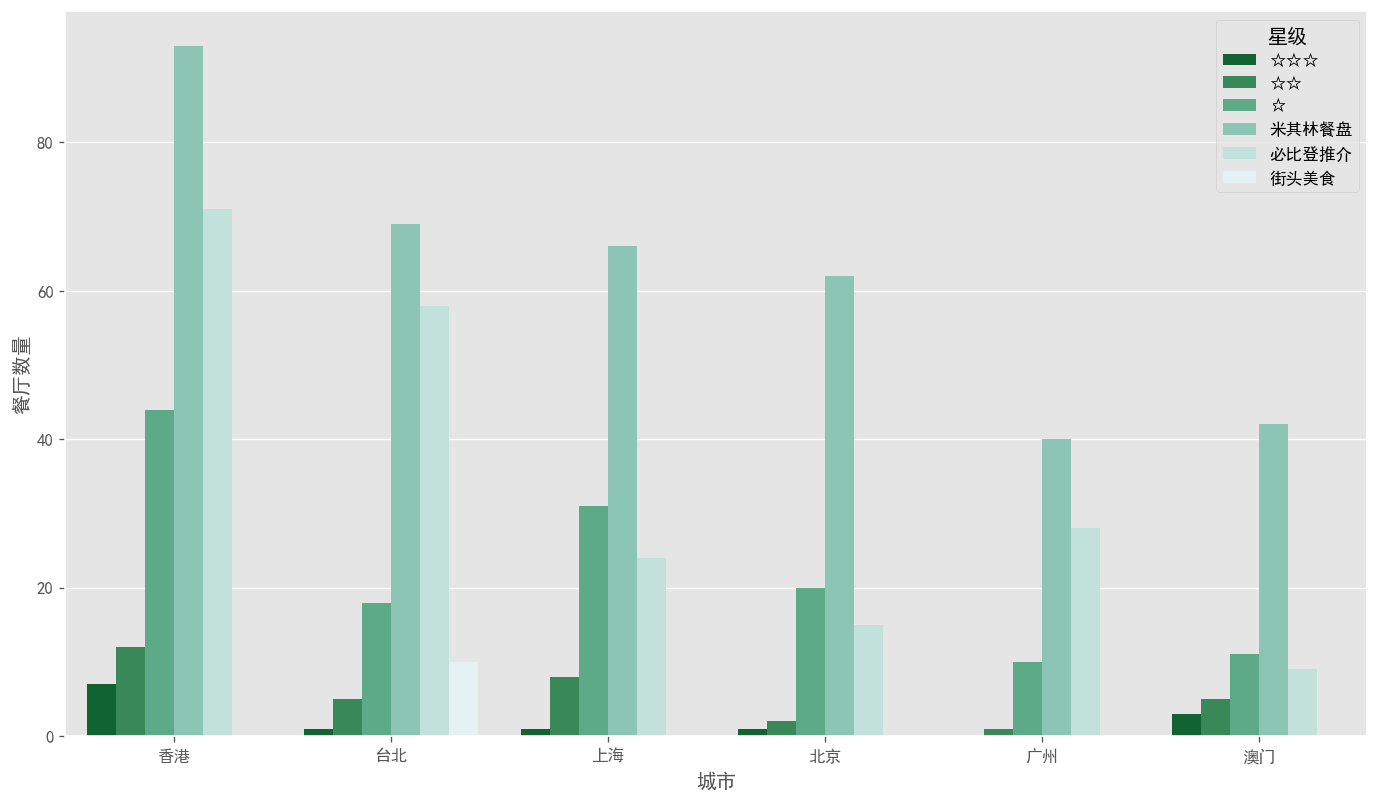

In [21]:
fig = plt.figure(figsize=(14,8), dpi=120)
sns.barplot(x="城市",y="餐厅数量",hue="星级",data=city_df,palette='BuGn_r')
plt.savefig("2-米其林各城市分类对比.jpg")
plt.show()

In [22]:
city_df.to_excel('米其林分城市分类型餐厅数量.xlsx')

# 米其林餐厅价格

In [105]:
# 只选择米其林餐厅
only_mic_df = michelin_df[michelin_df['star'].isin(['☆','☆☆','☆☆☆'])]
# 过滤掉单点价格为空的，保存为晚间单点df
only_mic_menu_df = only_mic_df[(only_mic_df['mcl_dinner_menu_min'] != '') & (only_mic_df['mcl_dinner_menu_max'] != '')]
only_mic_menu_df[['mcl_dinner_menu_min','mcl_dinner_menu_max']] = only_mic_menu_df[['mcl_dinner_menu_min','mcl_dinner_menu_max']].astype('int')
only_mic_menu_df['mcl_dinner_menu_avg'] = (only_mic_menu_df['mcl_dinner_menu_min'] + only_mic_menu_df['mcl_dinner_menu_max']) / 2
only_mic_menu_df = only_mic_menu_df.reset_index()
# 排序
only_mic_menu_df['city_weight'] = ''
for i in range(len(only_mic_menu_df)):
    only_mic_menu_df.loc[i, 'city_weight'] = city_num_weight_dic[only_mic_menu_df.loc[i, 'city']]
only_mic_menu_df = only_mic_menu_df.sort_values('city_weight', ascending=False)

# # 过滤掉单点价格为空的，保存为午间单点df
# only_mic_menu_df_lunch = only_mic_df[(only_mic_df['mcl_lunch_menu_min'] != '') & (only_mic_df['mcl_lunch_menu_max'] != '')]
# only_mic_menu_df_lunch[['mcl_lunch_menu_min','mcl_lunch_menu_max']] = only_mic_menu_df_lunch[['mcl_lunch_menu_min','mcl_lunch_menu_max']].astype('int')
# only_mic_menu_df_lunch['mcl_lunch_menu_avg'] = (only_mic_menu_df_lunch['mcl_lunch_menu_min'] + only_mic_menu_df_lunch['mcl_lunch_menu_max']) / 2
# # 过滤掉套餐价格为空的，保存为套餐df
# only_mic_set_df = only_mic_df[(only_mic_df['mcl_dinner_set_min'] != '') & (only_mic_df['mcl_dinner_set_max'] != '')]
# only_mic_set_df[['mcl_dinner_set_min','mcl_dinner_set_max']] = only_mic_set_df[['mcl_dinner_set_min','mcl_dinner_set_max']].astype('int')
# only_mic_set_df['mcl_dinner_set_avg'] = (only_mic_set_df['mcl_dinner_set_min'] + only_mic_set_df['mcl_dinner_set_max']) / 2

/Users/patientman/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/patientman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [106]:
# 关键！对关键数据列进行货币转换
only_mic_menu_df[only_mic_menu_df['city'] == '香港']['mcl_dinner_menu_avg'] = only_mic_menu_df[only_mic_menu_df['city'] == '香港']['mcl_dinner_menu_avg'] * 0.8977
only_mic_menu_df[only_mic_menu_df['city'] == '台北']['mcl_dinner_menu_avg'] = only_mic_menu_df[only_mic_menu_df['city'] == '台北']['mcl_dinner_menu_avg'] * 0.2312
only_mic_menu_df[only_mic_menu_df['city'] == '澳门']['mcl_dinner_menu_avg'] = only_mic_menu_df[only_mic_menu_df['city'] == '澳门']['mcl_dinner_menu_avg'] * 0.8666

/Users/patientman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/patientman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/patientman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

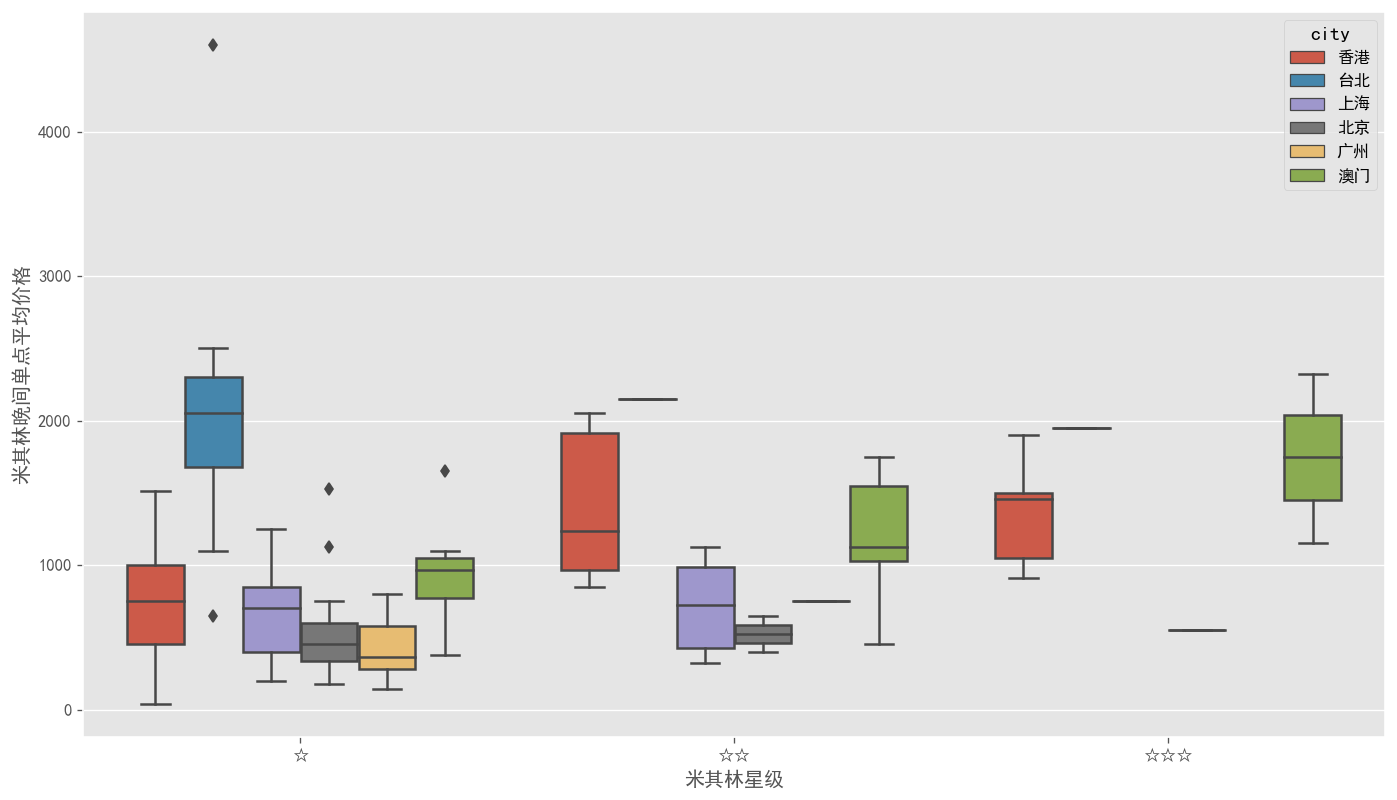

In [107]:
plt.figure(figsize=(14,8), dpi=120)
sns.boxplot(x='star', y='mcl_dinner_menu_avg', hue='city', data=only_mic_menu_df)
plt.xlabel('米其林星级',fontsize=12,verticalalignment='top')
plt.ylabel('米其林晚间单点平均价格',fontsize=12,horizontalalignment='center')
plt.savefig("3-米其林晚间单点平均价格.jpg")
plt.show()

In [108]:
only_mic_menu_df.to_excel('米其林星级餐厅价格数据.xlsx')

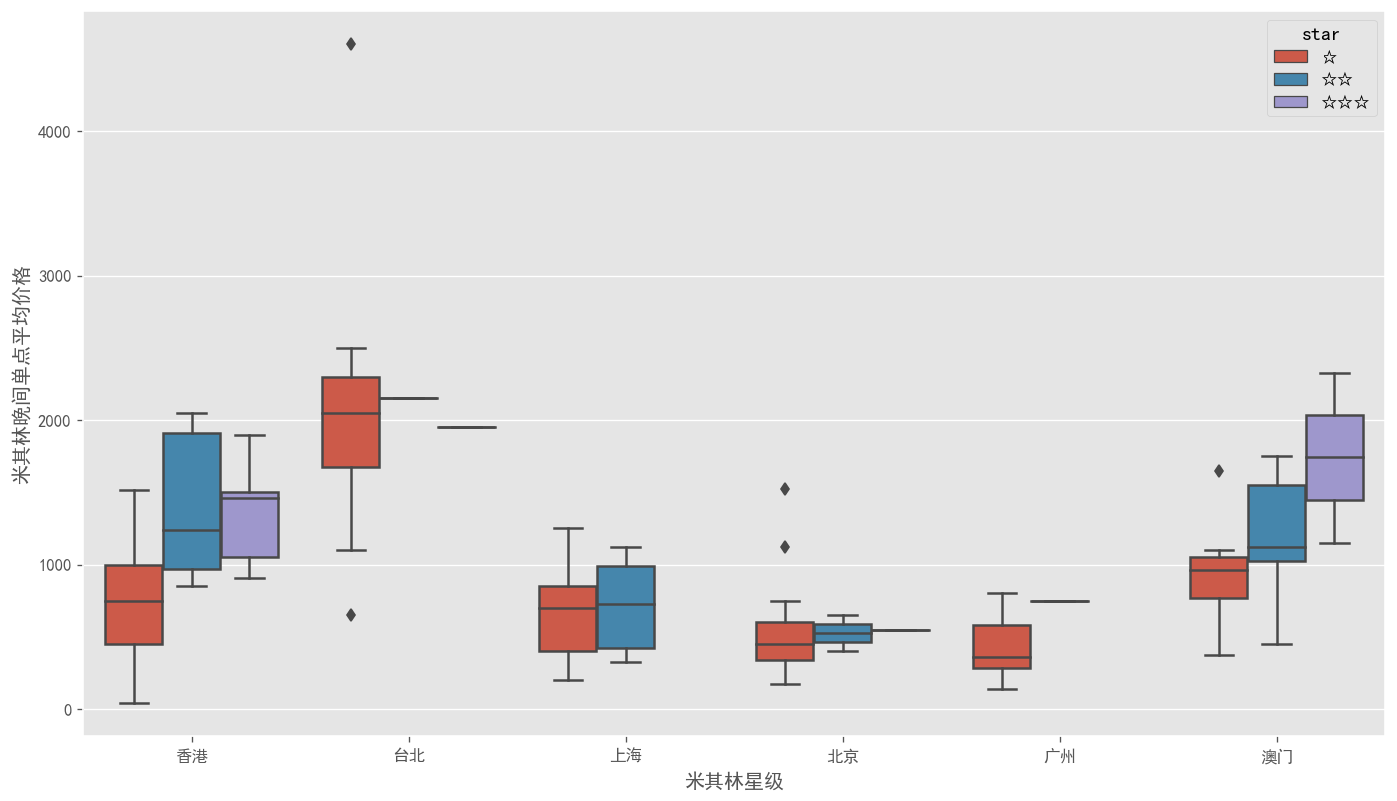

In [109]:
plt.figure(figsize=(14,8), dpi=120)
sns.boxplot(x='city', y='mcl_dinner_menu_avg', hue='star', data=only_mic_menu_df)
plt.xlabel('米其林星级',fontsize=12,verticalalignment='top')
plt.ylabel('米其林晚间单点平均价格',fontsize=12,horizontalalignment='center')
plt.savefig("4-米其林不同类型晚间单点平均价格.jpg")
plt.show()

In [110]:
# 只选择非星级餐厅
not_mic_df = michelin_df[michelin_df['star'].isin(['米其林餐盘','必比登推介','街头美食'])]
# 过滤掉单点价格为空的，保存为晚间单点df
not_mic_menu_df = not_mic_df[(not_mic_df['mcl_dinner_menu_min'] != '') & (not_mic_df['mcl_dinner_menu_max'] != '')]
not_mic_menu_df = not_mic_menu_df[~not_mic_menu_df['mcl_dinner_menu_max'].str.contains(',')] # 有"含,的金额向干扰"
not_mic_menu_df = not_mic_menu_df[~not_mic_menu_df['mcl_dinner_menu_min'].str.contains(',')] # 有"含,的金额向干扰"
not_mic_menu_df[['mcl_dinner_menu_min','mcl_dinner_menu_max']] = not_mic_menu_df[['mcl_dinner_menu_min','mcl_dinner_menu_max']].astype('int', errors='ignore')
not_mic_menu_df['mcl_dinner_menu_avg'] = (not_mic_menu_df['mcl_dinner_menu_min'] + not_mic_menu_df['mcl_dinner_menu_max']) / 2
not_mic_menu_df = not_mic_menu_df.reset_index()

In [111]:
# 关键！对关键数据列进行货币转换
not_mic_menu_df.loc[not_mic_menu_df.city == '香港', 'mcl_dinner_menu_avg'] = not_mic_menu_df.loc[not_mic_menu_df.city == '香港', 'mcl_dinner_menu_avg'] * 0.8977
not_mic_menu_df.loc[not_mic_menu_df.city == '台北', 'mcl_dinner_menu_avg'] = not_mic_menu_df.loc[not_mic_menu_df.city == '台北', 'mcl_dinner_menu_avg'] * 0.2312
not_mic_menu_df.loc[not_mic_menu_df.city == '澳门', 'mcl_dinner_menu_avg'] = not_mic_menu_df.loc[not_mic_menu_df.city == '澳门', 'mcl_dinner_menu_avg'] * 0.8666

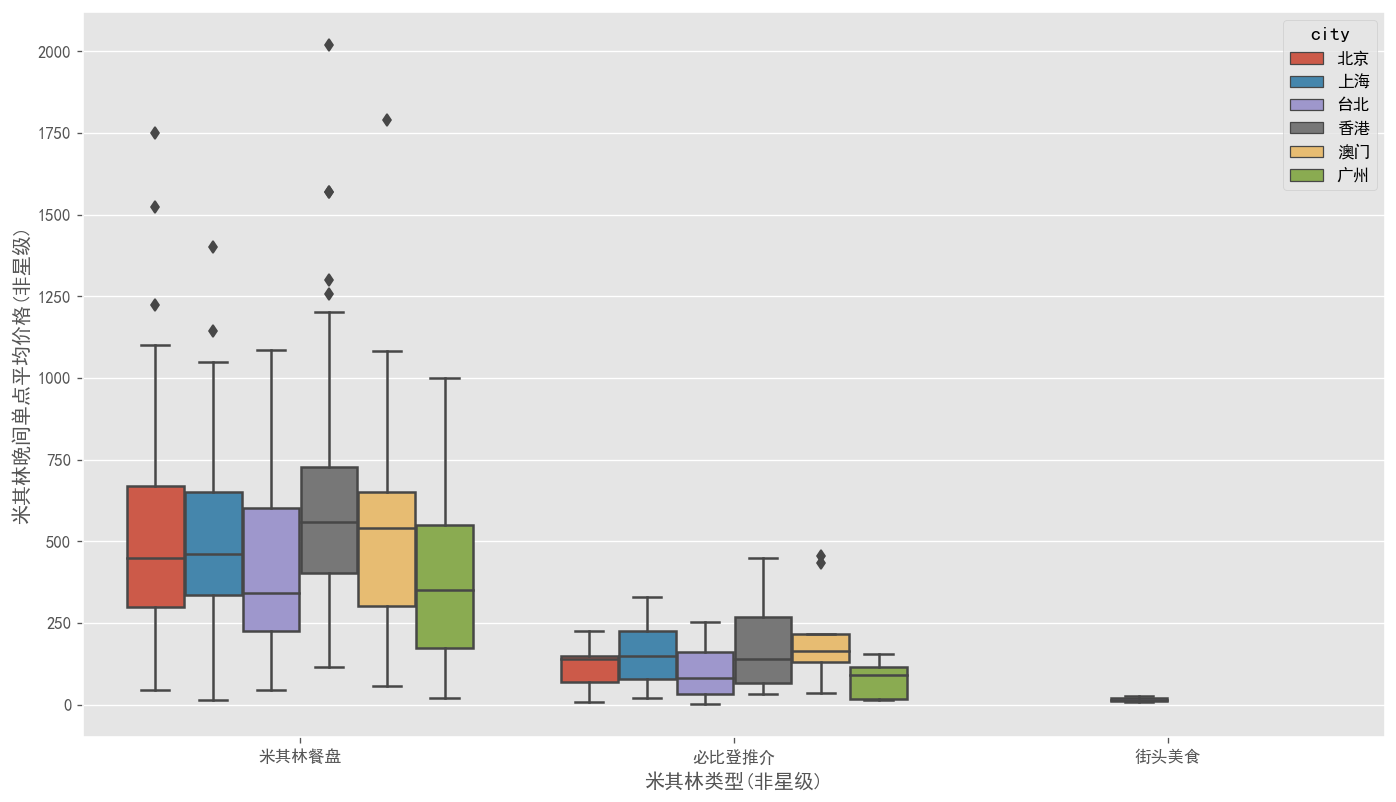

In [112]:
plt.figure(figsize=(14,8), dpi=120)
sns.boxplot(x='star', y='mcl_dinner_menu_avg', hue='city', data=not_mic_menu_df)
plt.xlabel('米其林类型(非星级)',fontsize=12,verticalalignment='top')
plt.ylabel('米其林晚间单点平均价格(非星级)',fontsize=12,horizontalalignment='center')
plt.savefig("4-米其林非星级餐厅晚间单点平均价格.jpg")
plt.show()

In [114]:
not_mic_menu_df.to_excel('米其林-非星级餐厅价格.xlsx')

In [73]:
not_mic_menu_df.loc[not_mic_menu_df.city == '台北', 'mcl_dinner_menu_avg']

2      2250.0
3      1100.0
7       750.0
8       200.0
10     3250.0
        ...  
467    4700.0
475     145.0
479      70.0
491    1200.0
492    1450.0
Name: mcl_dinner_menu_avg, Length: 100, dtype: float64

# test data (请忽略)

In [30]:
# 单点

In [31]:
beijing_df = michelin_df[(michelin_df['city'] == '香港') & (michelin_df['star'].isin(['☆','☆☆','☆☆☆'])) ]
menu_min_df = beijing_df[['mcl_name', 'mcl_dinner_menu_min']]
menu_min_df = menu_min_df[menu_min_df['mcl_dinner_menu_min'] != '']
menu_min_df['mcl_dinner_menu_min'] = menu_min_df['mcl_dinner_menu_min'].astype('int')
menu_min_df.sort_values('mcl_dinner_menu_min')

,mcl_name,mcl_dinner_menu_min
78,添好运 (深水埗),30
351,甘牌烧鹅,50
660,一乐烧鹅,60
572,何洪记,100
505,利苑酒家 (观塘),150
529,呇 (湾仔),200
306,六福菜馆,200
91,苏浙汇 (湾仔),200
244,彭庆记,250
219,夜上海 (尖沙咀),250


In [32]:
beijing_df = michelin_df[(michelin_df['city'] == '香港') & (michelin_df['star'].isin(['☆','☆☆','☆☆☆'])) ]
menu_max_df = beijing_df[['mcl_name', 'mcl_dinner_menu_max']]
menu_max_df = menu_max_df[menu_max_df['mcl_dinner_menu_max'] != '']
menu_max_df['mcl_dinner_menu_max'] = menu_max_df['mcl_dinner_menu_max'].astype('int')
menu_max_df.sort_values('mcl_dinner_menu_max')

,mcl_name,mcl_dinner_menu_max
78,添好运 (深水埗),50
351,甘牌烧鹅,150
572,何洪记,200
660,一乐烧鹅,360
306,六福菜馆,500
732,浙江轩,500
91,苏浙汇 (湾仔),500
244,彭庆记,500
219,夜上海 (尖沙咀),600
505,利苑酒家 (观塘),750


In [33]:
len(menu_min_df)

50

In [34]:
# 套餐

In [35]:
set_min_df = michelin_df[michelin_df['city'] == '北京']

In [36]:
set_min_df = set_min_df[['mcl_name', 'mcl_dinner_set_min']]

In [37]:
set_min_df = set_min_df[set_min_df['mcl_dinner_set_min'] != '']

In [38]:
set_min_df['mcl_dinner_set_min'] = set_min_df['mcl_dinner_set_min'].astype('int')

In [39]:
set_min_df.sort_values('mcl_dinner_set_min')

,mcl_name,mcl_dinner_set_min
404,大里院子,160
562,莲花空间 (金城坊街),200
309,席,295
415,厉家菜 (西城),298
216,恰 (南三里屯路),298
534,淮扬府,300
35,左岸,300
586,霖舍,388
497,Jing,480
288,Trb Hutong,498


In [40]:
set_min_df

,mcl_name,mcl_dinner_set_min
35,左岸,300
55,福楼,998
197,The Georg,650
216,恰 (南三里屯路),298
220,Mio,698
236,聚,1038
255,鸢尾宫 1893,638
288,Trb Hutong,498
309,席,295
334,晟永兴 (朝阳),588


In [41]:
michelin_df

,mcl_id,mcl_name,mcl_star,mcl_poi,mcl_address,mcl_short_address,mcl_has_set,mcl_dinner_menu_min,mcl_dinner_menu_max,mcl_dinner_set_min,mcl_dinner_set_max,mcl_lunch_menu_min,mcl_lunch_menu_max,mcl_lunch_set_min,mcl_lunch_set_max,mcl_city,star,city
0,0038EE79-9904-BD54-D883-DF3B971C0CBF,禾家,D87A87B3-782B-4C02-83FE-C0467D934923,"116.474095,39.975138",朝阳区将台路甲2号诺金酒店1层,朝阳区,False,250,500,,,250,500,,,8D553380-2180-440A-8E3E-6F926CCB77F6,米其林餐盘,北京
1,00826A2D-7E19-6107-1ADA-E07AF3649C80,恰,D87A87B3-782B-4C02-83FE-C0467D934923,"121.495544,31.227837",黄浦区中山东二路585号外滩英迪格酒店29-31楼,黄浦区,False,500,2300,,,,,,,6B70D2A3-8061-F37D-73DB-355134A0521F,米其林餐盘,上海
2,00FBA8D9-13CD-81FE-1CCD-C2A22209ACF2,钰善阁,D87A87B3-782B-4C02-83FE-C0467D934923,"120.988108,24.778289",中正区北平东路14号,中正区,False,2000,2500,1298,4998,2000,2500,998,4998,834FA3FA-1B9F-4771-B43B-A43F3FE940CC,米其林餐盘,台北
3,0148FF1A-7DE0-4791-95BB-487D5C8B18DD,旅,DC960ECC-E15B-46E2-89F5-B44EC31743F1,"114.15529,22.282766",中环士丹利街21号中环石板街酒店2楼,中环,False,,,,,,,,,ECCFF058-9506-4187-536C-EE8A39B5D79D,☆☆,香港
4,01888967-28DE-9414-2BD3-72ACEEE292C2,页小馆,D87A87B3-782B-4C02-83FE-C0467D934923,"121.547774,25.08184",中山区北安路595巷20弄4号,中山区,False,600,1600,,,600,1600,,,834FA3FA-1B9F-4771-B43B-A43F3FE940CC,米其林餐盘,台北
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,FC9C5B69-60F4-2244-F0B4-F0EAA5CFF2A2,帝雅廷,D87A87B3-782B-4C02-83FE-C0467D934923,"113.54587,22.188116",外港新填海区仙德丽街永利酒店一楼,澳门,False,500,1000,,,,,,,38E469DD-34B7-347A-9C77-D0B1F326B0C5,米其林餐盘,澳门
763,FD5AB57D-7C71-4C98-B446-22513AFDE2E4,鼎泰丰 (铜锣湾),DE23F387-79CE-4992-9398-697AE70F017C,"114.1856,22.27991",铜锣湾怡和街68号地下G3-G11号铺,铜锣湾,False,,,,,150,280,,,ECCFF058-9506-4187-536C-EE8A39B5D79D,必比登推介,香港
764,FDCD0C18-B0E5-4D55-990E-9A56CA14DE31,Sushi Masataka,D87A87B3-782B-4C02-83FE-C0467D934923,"114.17702,22.27643",湾仔活道18号萃峯地下,湾仔,False,,,,,,,,,ECCFF058-9506-4187-536C-EE8A39B5D79D,米其林餐盘,香港
765,FEE9E20D-FB6F-164E-0D99-D81D65DD1CFE,漫活堂‧臻选有机,D87A87B3-782B-4C02-83FE-C0467D934923,"113.32771,23.116484",天河区冼村路5号凯华国际中心2楼205号铺,天河区,False,150,250,,,150,250,,,E9E7F1CC-2414-4FB1-AC40-282424CC36ED,米其林餐盘,广州
